In [1]:
# import modules
%pylab inline

import os
import numpy as np
import pandas as pd
from scipy.misc import imread

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, InputLayer
from keras.regularizers import L1L2

Populating the interactive namespace from numpy and matplotlib


/home/ujjawal/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# to stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [3]:
# set path
root_dir = os.path.abspath('.')
data_dir = os.path.join(root_dir, 'Data')

In [4]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("/home/ujjawal/GAN/Data/train-images.idx3-ubyte", "/home/ujjawal/GAN/Data/train-labels.idx1-ubyte",
        "mnist_train.csv", 60000)
convert("/home/ujjawal/GAN/Data/t10k-images.idx3-ubyte", "/home/ujjawal/GAN/Data/t10k-labels.idx1-ubyte",
        "mnist_test.csv", 10000)

In [4]:
# load data
train = pd.read_csv(os.path.join(data_dir,'mnist_train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'mnist_test.csv'))


In [5]:
train1=list(train.values)
len(train1)

59999

In [6]:
n1=(np.asarray(train1[0][:-1])).reshape(28,28)

In [7]:
n1.shape

(28, 28)

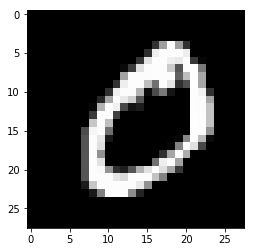

In [8]:
plt.imshow(np.uint8(n1),cmap='gray')

In [9]:
test1=list(test.values)

In [10]:
len(test1)

9999

In [11]:
n2=(np.asarray(test1[0][:-1])).reshape(28,28)

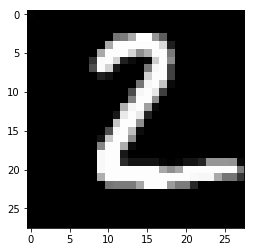

In [12]:
plt.imshow(np.uint8(n2),cmap='gray')

In [13]:
train_1=[]
for i in range(len(train1)):
    n1=(np.asarray(train1[i][:-1])).reshape(28,28)
    train_1.append(n1)

In [14]:
train_x = np.stack(train_1)

train_x = train_x / 255

In [15]:
g_input_shape = 100 
d_input_shape = (28, 28) 
hidden_1_num_units = 500 
hidden_2_num_units = 500 
g_output_num_units = 784 
d_output_num_units = 1 
epochs = 25 
batch_size = 128

In [16]:
# generator
model_1 = Sequential([
    Dense(units=hidden_1_num_units, input_dim=g_input_shape, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),

    Dense(units=hidden_2_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
        
    Dense(units=g_output_num_units, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
    
    Reshape(d_input_shape),
])

# discriminator
model_2 = Sequential([
    InputLayer(input_shape=d_input_shape),
    
    Flatten(),
        
    Dense(units=hidden_1_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),

    Dense(units=hidden_2_num_units, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
        
    Dense(units=d_output_num_units, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               50500     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               392784    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 693,784
Trainable params: 693,784
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 501       
Total params: 643,501
Trainable params: 643,501
Non-trainable params: 0
_________________________________________________________________


In [19]:
from keras_adversarial import AdversarialModel, simple_gan, gan_targets
from keras_adversarial import AdversarialOptimizerSimultaneous, normal_latent_sampling

In [20]:
gan = simple_gan(model_1, model_2, normal_latent_sampling((100,)))

In [21]:
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 100)          0           input_1[0][0]                    
__________________________________________________________________________________________________
gan (Model)                     [(None, 1), (None, 1 1337285     lambda_1[0][0]                   
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
yfake (Activation)              (None, 1)            0           gan[1][0]                        
__________

In [22]:
model = AdversarialModel(base_model=gan,player_params=[model_1.trainable_weights, model_2.trainable_weights])

In [23]:
model.adversarial_compile(adversarial_optimizer=AdversarialOptimizerSimultaneous(), player_optimizers=['adam', 'adam'], loss='binary_crossentropy')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [24]:
history = model.fit(x=train_x, y=gan_targets(train_x.shape[0]), epochs=10, batch_size=batch_size)

Epoch 1/10
59999/59999 [==============================] - 47s 780us/step - loss: 25.9758 - player_0_loss: 23.9149 - player_0_yfake_loss: 12.1936 - player_0_yreal_loss: 9.6888 - player_1_loss: 2.0610 - player_1_yfake_loss: 0.0101 - player_1_yreal_loss: 0.0184
Epoch 2/10
59999/59999 [==============================] - 47s 777us/step - loss: 26.3402 - player_0_loss: 25.1735 - player_0_yfake_loss: 14.2790 - player_0_yreal_loss: 9.7929 - player_1_loss: 1.1667 - player_1_yfake_loss: 0.0300 - player_1_yreal_loss: 0.0351
Epoch 3/10
59999/59999 [==============================] - 46s 763us/step - loss: 30.1818 - player_0_loss: 29.2746 - player_0_yfake_loss: 16.1181 - player_0_yreal_loss: 12.2498 - player_1_loss: 0.9072 - player_1_yfake_loss: 1.0000e-07 - player_1_yreal_loss: 5.8292e-04
Epoch 4/10
59999/59999 [==============================] - 45s 743us/step - loss: 28.5768 - player_0_loss: 27.8829 - player_0_yfake_loss: 16.0615 - player_0_yreal_loss: 11.1357 - player_1_loss: 0.6939 - player_1_yfa

In [25]:
keras.__version__

'2.1.5'

In [27]:
!pip install keras==2.1.2

    100% |████████████████████████████████| 307kB 731kB/s ta 0:00:01
  Found existing installation: Keras 2.1.5
    Uninstalling Keras-2.1.5:
      Successfully uninstalled Keras-2.1.5
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


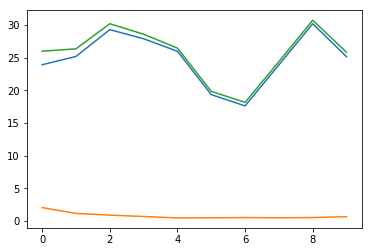

In [25]:
plt.plot(history.history['player_0_loss'])
plt.plot(history.history['player_1_loss'])
plt.plot(history.history['loss'])

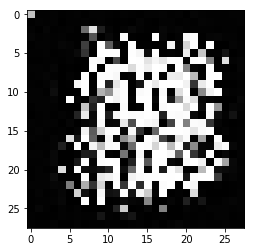

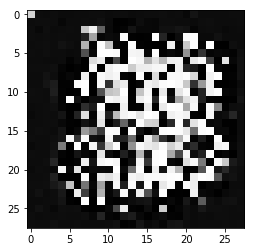

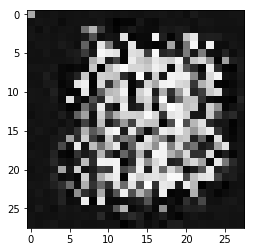

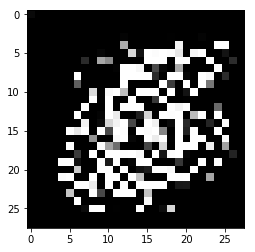

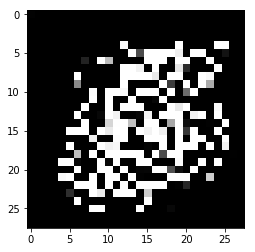

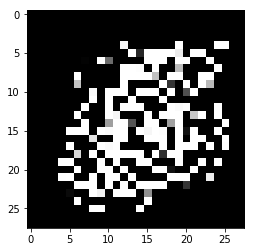

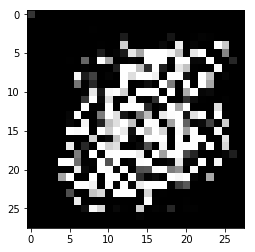

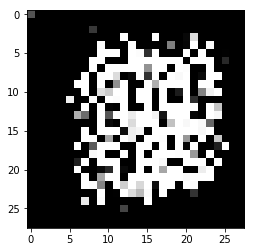

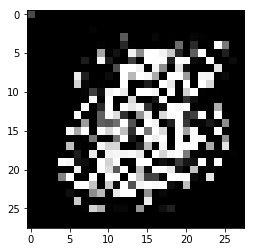

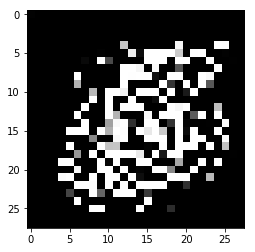

In [26]:
zsamples = np.random.normal(size=(10, 100))
pred = model_1.predict(zsamples)
for i in range(pred.shape[0]):
    plt.imshow(pred[i, :], cmap='gray')
    plt.show()